Lectura de archivo en excel con todas sus hojas

In [180]:
# Importar las librerías necesarias
import pandas as pd

# Especificar la ruta del archivo en "files"
file_path = '/home/elicoubuntu/Desktop/Industrial_Insigths/Prognosis/subestacion _canaima _1000kva.xlsx'

# Cargar el archivo de Excel
excel_data = pd.ExcelFile(file_path)

# Ver las hojas del archivo de Excel
excel_data.sheet_names


['tension',
 'corriente',
 'energia',
 'Factor P',
 'Flickers (Pst)',
 'Flickers (Plt)',
 'Frecuencia',
 'potencia A',
 'Potencia Aparente',
 'potencia R I',
 'Distorsion armonica',
 'Armonicos  IL1',
 'Armonicos  IL2',
 'Armonicos  IL3',
 'Armonicos  VL1',
 'Armonicos  VL2',
 'Armonicos  VL3']

Consolidacion de datos es un solo data set por marca de tiempo

In [196]:
# Función para consolidar las hojas del Excel basadas en 'Fecha' y 'Tiempo'
def consolidate_sheets(excel_data, sheet_names):
    consolidated_df = None
    
    for sheet in sheet_names:
        sheet_df = excel_data.parse(sheet)
        
        # Combinar Fecha y Tiempo en una sola columna timestamp
        if 'Fecha' in sheet_df.columns and 'Tiempo' in sheet_df.columns:
            # Convertir 'Fecha' a string si es necesario
            if pd.api.types.is_datetime64_any_dtype(sheet_df['Fecha']):
                sheet_df['Fecha'] = sheet_df['Fecha'].dt.strftime('%Y-%m-%d')
            
            # Convertir 'Tiempo' a string si es de tipo datetime.time
            sheet_df['Tiempo'] = sheet_df['Tiempo'].apply(lambda x: x.strftime('%H:%M:%S') if isinstance(x, pd._libs.tslibs.timestamps.Timestamp) or isinstance(x, pd._libs.tslibs.nattype.NaTType) else x.strftime('%H:%M:%S'))
            
            # Crear la columna timestamp
            sheet_df['timestamp'] = pd.to_datetime(sheet_df['Fecha'] + ' ' + sheet_df['Tiempo'])
            sheet_df = sheet_df.drop(columns=['Fecha', 'Tiempo'])
        
        # Unir todas las hojas
        if consolidated_df is None:
            consolidated_df = sheet_df
        else:
            consolidated_df = pd.merge(consolidated_df, sheet_df, on='timestamp', how='outer')

    return consolidated_df

# Consolidar las hojas
sheet_names = excel_data.sheet_names
consolidated_data = consolidate_sheets(excel_data, sheet_names)

# Ver una muestra de los datos consolidados
print(consolidated_data.head())

# Guardar el DataFrame consolidado en un archivo Excel
output_excel_path = '/home/elicoubuntu/Desktop/Industrial_Insigths/Prognosis/consolidated_data.xlsx'
consolidated_data.to_excel(output_excel_path, index=False)

print(f"Datos consolidados guardados en: {output_excel_path}")


   Tensión MIN: L1 (V)  Tensión: L1 (V)  Tensión MAX: L1 (V)  \
0               264.21           264.42               264.73   
1               264.37           264.73               264.93   
2               264.57           264.78               265.02   
3               264.54           264.77               265.00   
4               264.50           264.85               265.07   

   Tensión MIN: L2 (V)  Tensión: L2 (V)  Tensión MAX: L2 (V)  \
0               268.12           268.32               268.46   
1               268.42           268.59               268.80   
2               268.52           268.65               268.85   
3               268.29           268.60               268.88   
4               268.41           268.65               268.85   

   Tensión MIN: L3 (V)  Tensión: L3 (V)  Tensión MAX: L3 (V)  \
0               266.51           266.73               266.92   
1               266.69           266.98               267.20   
2               266.87           267.0

In [197]:
consolidated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7141 entries, 0 to 7140
Columns: 382 entries, Tensión MIN: L1 (V) to Armónicos VL3: Armónico 50 (%VL3)
dtypes: datetime64[ns](1), float64(111), int64(267), object(3)
memory usage: 20.8+ MB


Validacion de datos

In [198]:
# Validación de los datos consolidados

# 1. Verificar si hay valores faltantes
missing_data = consolidated_data.isnull().sum()
print("Valores faltantes por columna:")
print(missing_data[missing_data > 0])

# 2. Verificar si hay registros duplicados basados en 'timestamp'
duplicates = consolidated_data.duplicated(subset='timestamp').sum()
print(f"\nNúmero de registros duplicados: {duplicates}")

# 3. Verificar los tipos de datos de las columnas
print("\nTipos de datos por columna:")
print(consolidated_data.dtypes)

# 4. Generar estadísticas descriptivas de las columnas numéricas
print("\nEstadísticas descriptivas:")
print(consolidated_data.describe())


Valores faltantes por columna:
Series([], dtype: int64)

Número de registros duplicados: 0

Tipos de datos por columna:
Tensión MIN: L1 (V)                  float64
Tensión: L1 (V)                      float64
Tensión MAX: L1 (V)                  float64
Tensión MIN: L2 (V)                  float64
Tensión: L2 (V)                      float64
                                      ...   
Armónicos VL3: Armónico 46 (%VL3)      int64
Armónicos VL3: Armónico 47 (%VL3)      int64
Armónicos VL3: Armónico 48 (%VL3)      int64
Armónicos VL3: Armónico 49 (%VL3)      int64
Armónicos VL3: Armónico 50 (%VL3)      int64
Length: 382, dtype: object

Estadísticas descriptivas:
       Tensión MIN: L1 (V)  Tensión: L1 (V)  Tensión MAX: L1 (V)  \
count          7141.000000      7141.000000          7141.000000   
mean            264.445552       264.734348           265.000815   
min             257.010000       258.960000           259.320000   
25%             262.740000       263.040000           263.

Normalización de los datos y clustering con K-Means

In [184]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Seleccionar solo las columnas numéricas para normalizar
numerical_columns = consolidated_data.select_dtypes(include=['float64', 'int64']).columns

# Normalizar los datos usando StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(consolidated_data[numerical_columns])

# Aplicar K-Means con un número de clusters, 
kmeans_4 = KMeans(n_clusters=4, random_state=42)
kmeans_4.fit(scaled_data)

# Agregar los resultados del clustering al dataframe consolidado
consolidated_data['Cluster'] = kmeans_4.labels_

# Mostrar una muestra de los datos con los clusters asignados
print(consolidated_data[['timestamp', 'Cluster']].head())
# Ver las primeras filas del DataFrame completo
print("Primeras filas del DataFrame:")
print(consolidated_data.head())


            timestamp  Cluster
0 2013-05-04 16:07:00        2
1 2013-05-04 16:08:00        2
2 2013-05-04 16:09:00        2
3 2013-05-04 16:10:00        2
4 2013-05-04 16:11:00        2
Primeras filas del DataFrame:
   Tensión MIN: L1 (V)  Tensión: L1 (V)  Tensión MAX: L1 (V)  \
0               264.21           264.42               264.73   
1               264.37           264.73               264.93   
2               264.57           264.78               265.02   
3               264.54           264.77               265.00   
4               264.50           264.85               265.07   

   Tensión MIN: L2 (V)  Tensión: L2 (V)  Tensión MAX: L2 (V)  \
0               268.12           268.32               268.46   
1               268.42           268.59               268.80   
2               268.52           268.65               268.85   
3               268.29           268.60               268.88   
4               268.41           268.65               268.85   

   Tensión MIN

determinar el número óptimo de clusters:Método del Codo, Mide la suma de las distancias al centroide (inercia) y grafica esta métrica a medida que se aumenta el número de clusters. se busca un "codo" en la gráfica, donde agregar más clusters no mejora significativamente la inercia.

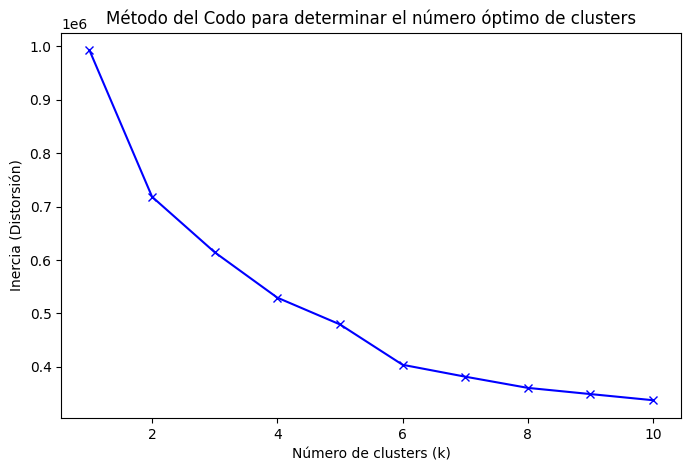

In [185]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Probar diferentes valores de k (número de clusters)
distortions = []
K = range(1, 11)  # Prueba desde 1 hasta 10 clusters
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    distortions.append(kmeans.inertia_)  # Guardar la inercia (distancia al centroide)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (Distorsión)')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.show()

Normalizacion y cluster con 4

In [186]:
# Ver la distribución de los registros en los diferentes clusters
cluster_distribution = consolidated_data['Cluster'].value_counts()

# Mostrar la cantidad de datos asignados a cada cluster
print("Distribución de los registros en los clusters:")
print(cluster_distribution)


Distribución de los registros en los clusters:
Cluster
3    2330
1    2216
0    1507
2    1088
Name: count, dtype: int64


Centroides de los Clusters

In [187]:
# Obtener los centroides del modelo K-Means con 4 clusters
centroids_4_clusters = kmeans_4.cluster_centers_

# Crear un DataFrame con los centroides y los nombres de las columnas
centroids_4_df = pd.DataFrame(centroids_4_clusters, columns=numerical_columns)

# Mostrar los centroides de los 4 clusters
print("Centroides de los 4 clusters:")
print(centroids_4_df)


Centroides de los 4 clusters:
   Tensión MIN: L1 (V)  Tensión: L1 (V)  Tensión MAX: L1 (V)  \
0             1.320040         1.324236             1.320515   
1             0.238214         0.239705             0.242394   
2            -0.334312        -0.341179            -0.347159   
3            -0.924228        -0.925153            -0.922511   

   Tensión MIN: L2 (V)  Tensión: L2 (V)  Tensión MAX: L2 (V)  \
0             1.333098         1.335617             1.333894   
1             0.234706         0.235977             0.236997   
2            -0.319450        -0.323559            -0.330172   
3            -0.936278        -0.937196            -0.933964   

   Tensión MIN: L3 (V)  Tensión: L3 (V)  Tensión MAX: L3 (V)  \
0             1.373791         1.378672             1.375974   
1             0.218996         0.219956             0.221833   
2            -0.421646        -0.426109            -0.433668   
3            -0.899935        -0.901920            -0.898431   

   Tens

In [188]:

# Obtener los centroides de los clusters
centroids = kmeans.cluster_centers_

# Crear un DataFrame con los centroides y los nombres de las columnas
centroids_df = pd.DataFrame(centroids, columns=numerical_columns)

# Mostrar los centroides
print("Centroides de los clusters:")
print(centroids_df)


Centroides de los clusters:
   Tensión MIN: L1 (V)  Tensión: L1 (V)  Tensión MAX: L1 (V)  \
0            -0.333973        -0.338523            -0.339471   
1            -0.339002        -0.331371            -0.327453   
2            -0.328992        -0.341986            -0.349747   
3             0.640159         0.640066             0.641006   
4             1.971140         1.984221             1.983110   
5            -0.015715        -0.009805            -0.005333   
6             1.809813         1.808727             1.797452   
7             0.350526         0.356688             0.361031   
8             0.759090         0.764378             0.764117   
9            -1.276328        -1.281132            -1.278120   

   Tensión MIN: L2 (V)  Tensión: L2 (V)  Tensión MAX: L2 (V)  \
0            -0.391829        -0.393895            -0.391192   
1            -0.410661        -0.404895            -0.401127   
2            -0.314410        -0.324254            -0.332639   
3          

Estadisticas por cluster

In [189]:
# Obtener estadísticas descriptivas por cluster
cluster_stats = consolidated_data.groupby('Cluster')[numerical_columns].describe()

# Mostrar estadísticas por cluster
print("Estadísticas descriptivas por cluster:")
print(cluster_stats)


Estadísticas descriptivas por cluster:
        Tensión MIN: L1 (V)                                                  \
                      count        mean       std     min       25%     50%   
Cluster                                                                       
0                    1507.0  267.733643  1.753418  263.85  266.3100  267.63   
1                    2216.0  265.038921  1.246401  259.75  264.0875  264.93   
2                    1088.0  263.612813  1.333269  257.01  262.6500  263.56   
3                    2330.0  262.143391  1.331168  257.46  261.1000  262.28   

                          Tensión: L1 (V)              ...  \
              75%     max           count        mean  ...   
Cluster                                                ...   
0        269.2200  270.74          1507.0  267.984559  ...   
1        265.9125  268.26          2216.0  265.322681  ...   
2        264.7125  266.92          1088.0  263.896958  ...   
3        263.1500  265.11          

visualización de clusters

Variables eléctricas clave que pueden ser las más importantes:

Tensiones de línea y fase (Tensión L1, L2, L3, y sus mínimas y máximas):

Razón: La estabilidad y calidad del suministro eléctrico depende directamente de la tensión. Cualquier desviación significativa en las tensiones, especialmente si se sale de los rangos permitidos, puede indicar problemas en el sistema, como sobrecargas, desequilibrio de fases, o incluso falla en transformadores.
Importancia: Las tensiones fuera de los rangos normales pueden generar sobrecalentamiento o desbalance que impacta en la eficiencia y puede ser indicativo de fallas inminentes.

Corrientes de fase (Corriente L1, L2, L3):

Razón: Las corrientes reflejan directamente el consumo de energía y las cargas conectadas al sistema. Un incremento o fluctuación en las corrientes puede estar relacionado con sobrecargas, cortocircuitos o fallas en los equipos de la subestación.
Importancia: Es esencial monitorear estas corrientes para detectar cualquier sobrecarga que podría derivar en un fallo.

Potencias (Aparente, Activa, Reactiva):

Razón: La potencia activa (kW) es la que realmente realiza trabajo útil, mientras que la potencia reactiva (kVAR) es necesaria para mantener los campos eléctricos y magnéticos en los equipos. Un desbalance entre estos dos tipos de potencias puede indicar problemas en la eficiencia energética o fallas en los equipos que generen exceso de consumo de energía reactiva.
Importancia: El exceso de potencia reactiva puede sobrecargar los transformadores y sistemas de distribución, mientras que la potencia activa refleja el trabajo real. El monitoreo de la potencia total (aparente) permite observar posibles sobrecargas.

Factor de potencia (FP):

Razón: Un factor de potencia bajo significa que se está consumiendo una gran cantidad de potencia reactiva en comparación con la potencia activa, lo cual es ineficiente y puede causar sobrecargas en el sistema.
Importancia: Es un indicador importante de eficiencia. Valores bajos deben corregirse y pueden estar asociados a fallas en los equipos de corrección del factor de potencia, como los condensadores.

Distorsión armónica (THD) en tensión y corriente:

Razón: La distorsión armónica indica la presencia de armónicos (frecuencias no deseadas) en la señal de tensión o corriente, que pueden provenir de equipos electrónicos no lineales o cargas como motores de velocidad variable o rectificadores. Estos armónicos causan pérdidas adicionales y posibles fallas en los transformadores y otros equipos.
Importancia: Niveles elevados de distorsión armónica pueden generar un sobrecalentamiento en los transformadores, aumentar las pérdidas y reducir la vida útil del equipo.

Temperatura de los transformadores y equipos:

Razón: Los sistemas eléctricos se ven afectados por el calor, especialmente los transformadores, que pueden sobrecalentarse bajo carga. Monitorear la temperatura ayuda a prevenir fallas térmicas.
Importancia: Las temperaturas fuera de rango pueden indicar problemas como sobrecarga, aislamiento defectuoso o mal funcionamiento de los sistemas de enfriamiento.

Frecuencia del sistema:

Razón: La frecuencia debe mantenerse constante en el sistema de distribución (normalmente alrededor de 50 o 60 Hz, dependiendo de la región). Cambios significativos en la frecuencia pueden ser una indicación de desbalance entre generación y consumo, o problemas serios en el sistema.
Importancia: Una frecuencia fuera del rango normal puede causar problemas en equipos sensibles y reflejar fallas en el sistema de control de la subestación.

Variables secundarias que podrían no ser prioritarias:

Armónicos de órdenes superiores (> 15): Si bien los armónicos de orden bajo pueden tener mayor impacto, los de órdenes más altos (20, 30, 40, etc.) pueden no ser tan críticos para la predicción de fallas en subestaciones.

Variables de eventos específicos: Dependiendo del sistema, algunos eventos puntuales o picos pueden ser menos importantes si ocurren con poca frecuencia o no afectan el consumo energético general.

Conclusión:
Las variables que reflejan el comportamiento general del sistema eléctrico, como tensiones, corrientes, potencias, distorsión armónica y factor de potencia, son las más importantes para la predicción de fallas. Variables relacionadas con condiciones específicas, como armónicos de orden alto o eventos puntuales, podrían ser consideradas secundarias y podrían eliminarse o reducirse en el análisis.

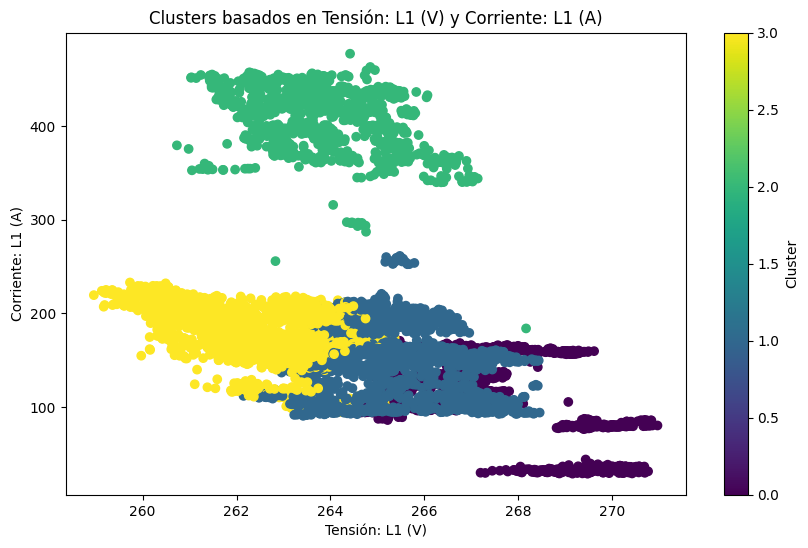

In [190]:
import matplotlib.pyplot as plt

# Seleccionar dos variables clave para visualizar
x_var = 'Tensión: L1 (V)'  # Variable en el eje X
y_var = 'Corriente: L1 (A)'  # Variable en el eje Y

# Graficar los clusters
plt.figure(figsize=(10, 6))
plt.scatter(consolidated_data[x_var], consolidated_data[y_var], c=consolidated_data['Cluster'], cmap='viridis')
plt.title('Clusters basados en {} y {}'.format(x_var, y_var))
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.colorbar(label='Cluster')
plt.show()


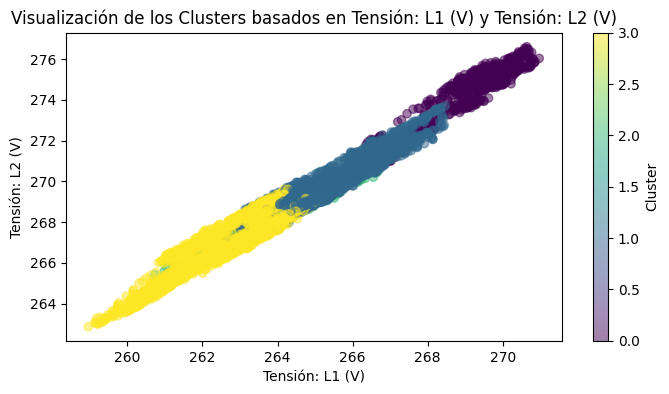

In [191]:
import matplotlib.pyplot as plt

# Seleccionar dos variables clave para visualizar
x_var = 'Tensión: L1 (V)'  # Variable en el eje X
y_var = 'Tensión: L2 (V)'  # Variable en el eje Y

# Graficar los clusters
plt.figure(figsize=(8, 4))
plt.scatter(consolidated_data[x_var], consolidated_data[y_var], c=consolidated_data['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Visualización de los Clusters basados en {} y {}'.format(x_var, y_var))
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.colorbar(label='Cluster')
plt.show()


In [192]:
from sklearn.metrics import silhouette_score

# Calcular el coeficiente de silueta
silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
print(f"Coeficiente de Silueta: {silhouette_avg}")


Coeficiente de Silueta: 0.27087700835004236


 Al observar un coeficiente bajo, puede ser una señal de que los clusters están solapados y es difícil diferenciarlos.

distancias de los puntos a sus centroides

In [193]:
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

# Calcular las distancias de cada punto al centroide más cercano
# 'pairwise_distances_argmin_min' devuelve dos cosas: 
# 1. índice del centroide más cercano (ya lo tenemos en 'Cluster')
# 2. la distancia mínima de cada punto al centroide correspondiente
distances_to_centroids, _ = pairwise_distances_argmin_min(scaled_data, kmeans_4.cluster_centers_)

# Agregar las distancias al DataFrame
consolidated_data['Distance_to_Centroid'] = distances_to_centroids

# Mostrar una muestra de los datos con las distancias añadidas
print(consolidated_data[['timestamp', 'Cluster', 'Distance_to_Centroid']].head())


            timestamp  Cluster  Distance_to_Centroid
0 2013-05-04 16:07:00        2                     2
1 2013-05-04 16:08:00        2                     2
2 2013-05-04 16:09:00        2                     2
3 2013-05-04 16:10:00        2                     2
4 2013-05-04 16:11:00        2                     2


In [195]:
# Calcular el percentil 95 de las distancias
threshold_percentile = np.percentile(consolidated_data['Distance_to_Centroid'], 80)

# Etiquetar como anomalías los puntos cuya distancia excede el percentil 95
consolidated_data['Anomaly'] = consolidated_data['Distance_to_Centroid'] > threshold_percentile

# Mostrar una muestra de los registros etiquetados como anomalías
print(consolidated_data[consolidated_data['Anomaly'] == True][['timestamp', 'Cluster', 'Distance_to_Centroid']].head())


Empty DataFrame
Columns: [timestamp, Cluster, Distance_to_Centroid]
Index: []


In [158]:
# Calcular la media y desviación estándar de las distancias
mean_distance = np.mean(consolidated_data['Distance_to_Centroid'])
std_distance = np.std(consolidated_data['Distance_to_Centroid'])

# Definir un umbral basado en 3 desviaciones estándar
threshold_std = mean_distance + 3 * std_distance

# Etiquetar como anomalías los puntos que exceden el umbral de desviación estándar
consolidated_data['Anomaly'] = consolidated_data['Distance_to_Centroid'] > threshold_std

# Mostrar una muestra de los registros etiquetados como anomalías
print(consolidated_data[consolidated_data['Anomaly'] == True][['timestamp', 'Cluster', 'Distance_to_Centroid']].head())


Empty DataFrame
Columns: [timestamp, Cluster, Distance_to_Centroid]
Index: []


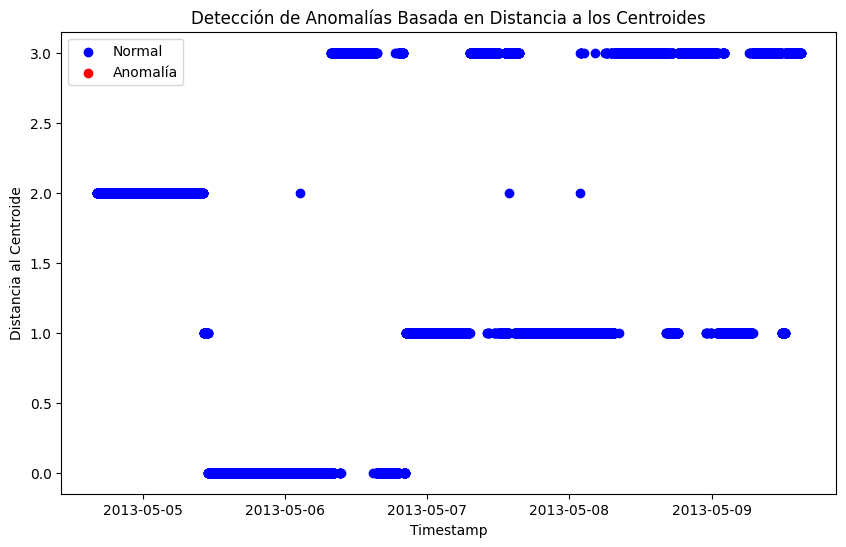

In [159]:
import matplotlib.pyplot as plt

# Visualizar las anomalías en función del tiempo y la distancia al centroide
plt.figure(figsize=(10, 6))

# Graficar los puntos normales
plt.scatter(consolidated_data['timestamp'], consolidated_data['Distance_to_Centroid'], 
            c='blue', label='Normal')

# Graficar los puntos anómalos
plt.scatter(consolidated_data[consolidated_data['Anomaly'] == True]['timestamp'], 
            consolidated_data[consolidated_data['Anomaly'] == True]['Distance_to_Centroid'], 
            c='red', label='Anomalía')

plt.xlabel('Timestamp')
plt.ylabel('Distancia al Centroide')
plt.title('Detección de Anomalías Basada en Distancia a los Centroides')
plt.legend()
plt.show()


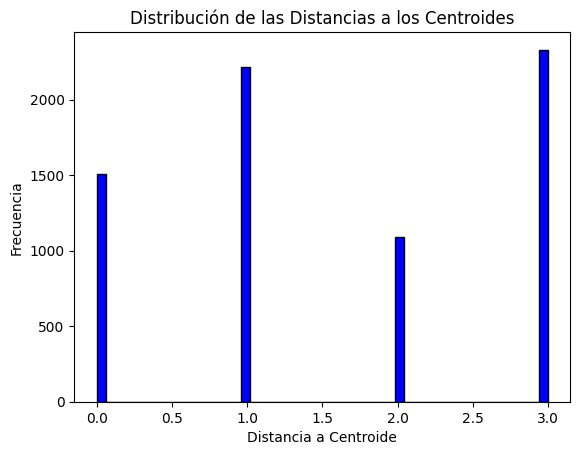

In [160]:
# Graficar un histograma de las distancias para ver la distribución
import matplotlib.pyplot as plt

plt.hist(consolidated_data['Distance_to_Centroid'], bins=50, color='blue', edgecolor='black')
plt.title('Distribución de las Distancias a los Centroides')
plt.xlabel('Distancia a Centroide')
plt.ylabel('Frecuencia')
plt.show()


In [161]:
# Usar la métrica Manhattan para calcular las distancias
from sklearn.metrics import pairwise_distances

manhattan_distances = pairwise_distances(scaled_data, kmeans_4.cluster_centers_, metric='manhattan')

# Usar la distancia mínima para detectar anomalías
consolidated_data['Distance_to_Centroid'] = manhattan_distances.min(axis=1)

# Intentar de nuevo con el umbral basado en percentiles
threshold_percentile = np.percentile(consolidated_data['Distance_to_Centroid'], 90)
consolidated_data['Anomaly'] = consolidated_data['Distance_to_Centroid'] > threshold_percentile

# Mostrar las posibles anomalías
print(consolidated_data[consolidated_data['Anomaly'] == True][['timestamp', 'Cluster', 'Distance_to_Centroid']].head())


              timestamp  Cluster  Distance_to_Centroid
633 2013-05-05 02:40:00        2            236.433211
816 2013-05-05 05:43:00        2             90.545752
818 2013-05-05 05:45:00        2             91.956281
819 2013-05-05 05:46:00        2             90.549242
821 2013-05-05 05:48:00        2             89.527799


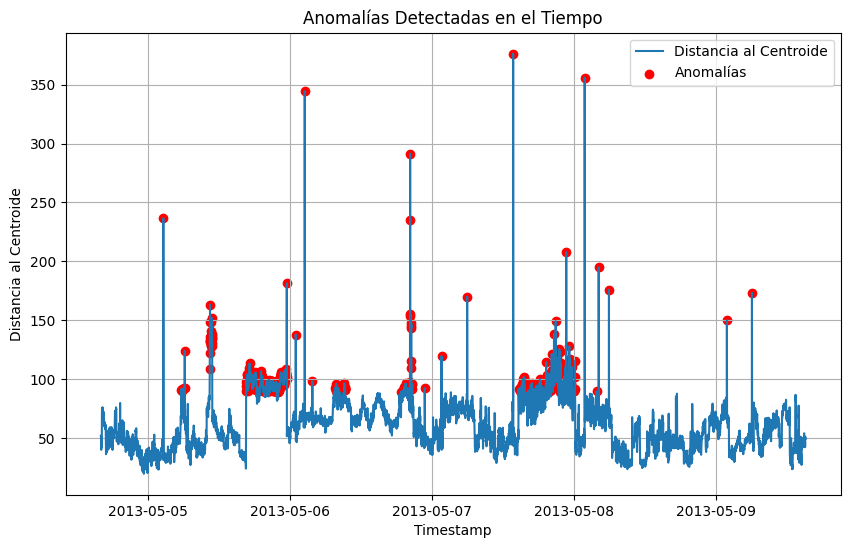

In [162]:
import matplotlib.pyplot as plt

# Filtrar los datos anómalos
anomalies = consolidated_data[consolidated_data['Anomaly'] == True]

# Visualizar las anomalías a lo largo del tiempo
plt.figure(figsize=(10, 6))

# Graficar todas las distancias
plt.plot(consolidated_data['timestamp'], consolidated_data['Distance_to_Centroid'], label='Distancia al Centroide')

# Resaltar las anomalías
plt.scatter(anomalies['timestamp'], anomalies['Distance_to_Centroid'], color='red', label='Anomalías')

plt.xlabel('Timestamp')
plt.ylabel('Distancia al Centroide')
plt.title('Anomalías Detectadas en el Tiempo')
plt.legend()
plt.grid(True)
plt.show()


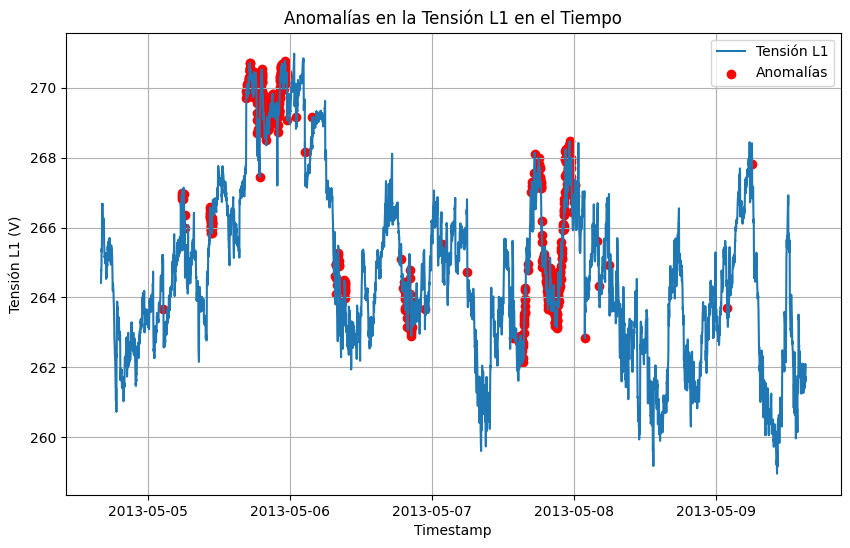

In [163]:
# Visualización de anomalías en relación con la Tensión L1
plt.figure(figsize=(10, 6))

# Graficar la Tensión L1 a lo largo del tiempo
plt.plot(consolidated_data['timestamp'], consolidated_data['Tensión: L1 (V)'], label='Tensión L1')

# Resaltar las anomalías
plt.scatter(anomalies['timestamp'], anomalies['Tensión: L1 (V)'], color='red', label='Anomalías')

plt.xlabel('Timestamp')
plt.ylabel('Tensión L1 (V)')
plt.title('Anomalías en la Tensión L1 en el Tiempo')
plt.legend()
plt.grid(True)
plt.show()


Número de anomalías detectadas: 143
              timestamp  Cluster  Anomaly
633 2013-05-05 02:40:00        2     True
634 2013-05-05 02:41:00        2     True
761 2013-05-05 04:48:00        2     True
814 2013-05-05 05:41:00        2     True
816 2013-05-05 05:43:00        2     True


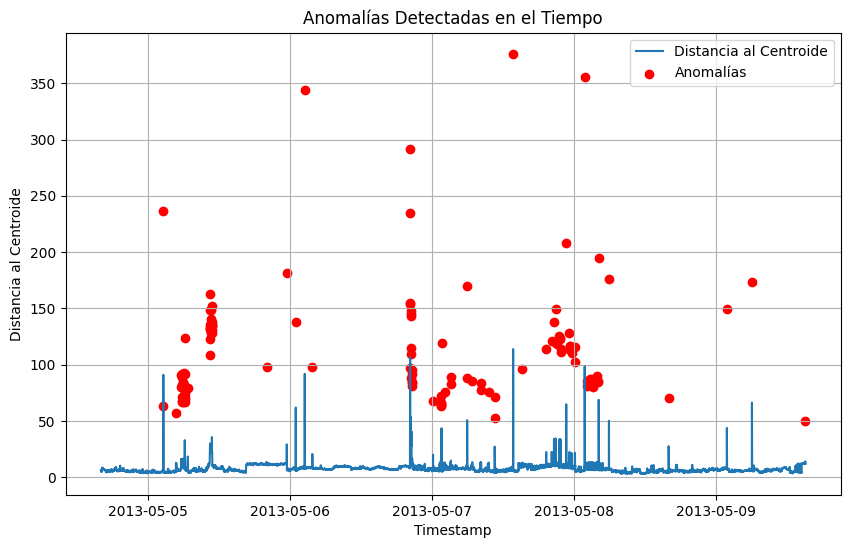

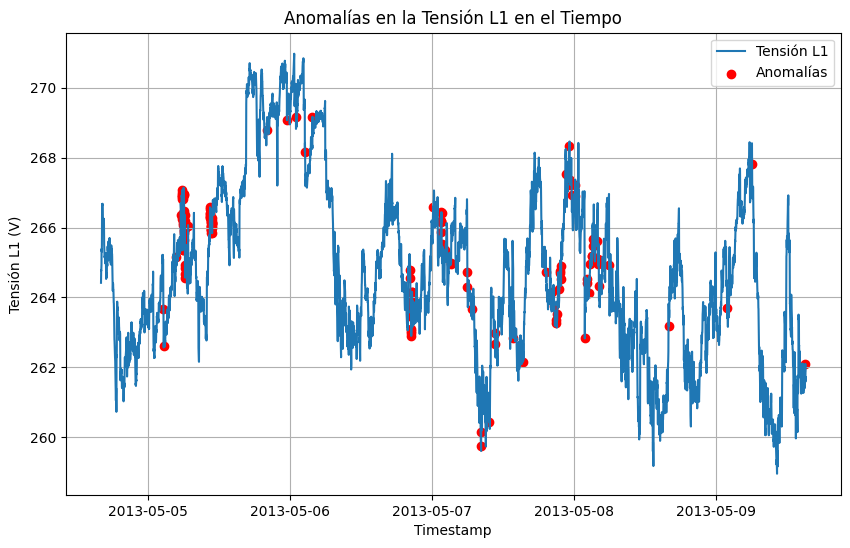

In [164]:
# Adjusting the variable name from 'consolidated_data_fixed_v2' to 'consolidated_data'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Seleccionar solo las columnas numéricas para normalizar
numerical_columns = consolidated_data.select_dtypes(include=['float64', 'int64']).columns

# Normalizar los datos numéricos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(consolidated_data[numerical_columns])

# Aplicar K-Means con el número de clusters deseado (por ejemplo, 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_data)

# Calcular las distancias de cada punto a los centroides
distances = kmeans.transform(scaled_data)

# Seleccionar la distancia al centroide asignado
assigned_distances = np.min(distances, axis=1)

# Definir un umbral para la detección de anomalías (e.g., percentil 95)
threshold = np.percentile(assigned_distances, 98)

# Etiquetar los registros como anomalías si su distancia excede el umbral
consolidated_data['Anomaly'] = assigned_distances > threshold

# Mostrar el número de anomalías detectadas y una muestra de los registros anómalos
num_anomalies = consolidated_data['Anomaly'].sum()
anomalies_sample = consolidated_data[consolidated_data['Anomaly']].head()

# Imprimir el número de anomalías y una muestra
print(f'Número de anomalías detectadas: {num_anomalies}')
print(anomalies_sample[['timestamp', 'Cluster', 'Anomaly']])

# Visualización de las anomalías detectadas a lo largo del tiempo

# Filtrar los datos anómalos
anomalies = consolidated_data[consolidated_data['Anomaly'] == True]

# Visualizar las anomalías a lo largo del tiempo
plt.figure(figsize=(10, 6))

# Graficar todas las distancias
plt.plot(consolidated_data['timestamp'], assigned_distances, label='Distancia al Centroide')

# Resaltar las anomalías
plt.scatter(anomalies['timestamp'], anomalies['Distance_to_Centroid'], color='red', label='Anomalías')

plt.xlabel('Timestamp')
plt.ylabel('Distancia al Centroide')
plt.title('Anomalías Detectadas en el Tiempo')
plt.legend()
plt.grid(True)
plt.show()

# Visualización adicional (ejemplo: anomalías en la Tensión L1)
plt.figure(figsize=(10, 6))

# Graficar Tensión L1
plt.plot(consolidated_data['timestamp'], consolidated_data['Tensión: L1 (V)'], label='Tensión L1')

# Resaltar las anomalías
plt.scatter(anomalies['timestamp'], anomalies['Tensión: L1 (V)'], color='red', label='Anomalías')

plt.xlabel('Timestamp')
plt.ylabel('Tensión L1 (V)')
plt.title('Anomalías en la Tensión L1 en el Tiempo')
plt.legend()
plt.grid(True)
plt.show()



In [169]:
consolidated_data.describe().head()

,Tensión MIN: L1 (V),Tensión: L1 (V),Tensión MAX: L1 (V),Tensión MIN: L2 (V),Tensión: L2 (V),Tensión MAX: L2 (V),Tensión MIN: L3 (V),Tensión: L3 (V),Tensión MAX: L3 (V),Tensión MIN: L1 - L2 (V),...,Armónicos VL3: Armónico 43 (%VL3),Armónicos VL3: Armónico 44 (%VL3),Armónicos VL3: Armónico 45 (%VL3),Armónicos VL3: Armónico 46 (%VL3),Armónicos VL3: Armónico 47 (%VL3),Armónicos VL3: Armónico 48 (%VL3),Armónicos VL3: Armónico 49 (%VL3),Armónicos VL3: Armónico 50 (%VL3),Cluster,Distance_to_Centroid
count,7141.000000,7141.000000,7141.000000,7141.0000,7141.000000,7141.000000,7141.000000,7141.000000,7141.000000,7141.000000,...,7141.0,7141.0,7141.0,7141.0,7141.0,7141.0,7141.0,7141.0,7141.000000,7141.000000
mean,264.445552,264.734348,265.000815,268.9878,269.272543,269.537904,266.972679,267.260634,267.526225,462.881256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.593894,61.084282
min,257.010000,258.960000,259.320000,260.8200,262.860000,263.220000,256.790000,261.300000,261.670000,450.460000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,19.661411
25%,262.740000,263.040000,263.320000,267.0700,267.360000,267.660000,265.170000,265.460000,265.740000,459.650000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,45.306605
50%,264.230000,264.480000,264.750000,268.7300,269.000000,269.260000,266.710000,266.990000,267.270000,462.480000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,59.012232


1. Medias por Clúster
Las medias nos ayudan a identificar cómo se comportan las diferentes variables dentro de cada clúster. Aquí se puede observar si un clúster se comporta de manera significativamente distinta a los demás en términos de variables clave, como:

Voltaje
Corriente
Potencia
Si uno de los clústeres tiene medias considerablemente más altas o más bajas para estas variables, podría estar representando un comportamiento atípico o una condición operativa diferente.

2. Desviaciones estándar (std)
La desviación estándar nos indica la variabilidad dentro de cada clúster. Si un clúster tiene una desviación estándar mucho más alta que los otros para una variable, esto puede ser indicativo de inestabilidad o fluctuaciones en el sistema que podrían ser consideradas anómalas.

Ejemplo:
Voltajes con alta desviación estándar: Esto podría indicar fluctuaciones peligrosas en la tensión que podrían dañar equipos o afectar la estabilidad del sistema.

3. Valores extremos (min y max)
Los valores mínimos y máximos dentro de cada clúster nos ayudan a ver los límites de operación. Si un clúster tiene valores máximos o mínimos extremos para una variable clave, esto podría ser un indicador de condiciones anormales o de funcionamiento en situaciones críticas.

Corrientes extremas: Si el clúster tiene valores máximos o mínimos inusuales en la corriente, podría estar indicando un sobreconsumo o una posible falla.
Potencias fuera de rango: Potencias muy por encima o por debajo del rango normal también son indicativos de fallos potenciales.

4. Comparación entre Clústeres
Al comparar los clústeres entre sí, podemos identificar si algún clúster parece estar agrupando datos con características más inestables o valores extremos en comparación con otros. Este tipo de análisis nos ayuda a determinar qué clústeres podrían representar situaciones operativas normales y cuáles podrían estar relacionados con comportamientos anormales o precursores de fallas.

Conclusiones preliminares:
Clústeres con desviaciones estándar elevadas: Un clúster que tiene una variabilidad alta en variables clave como voltaje o corriente debe ser examinado más de cerca, ya que puede estar señalando comportamientos inusuales.
Clústeres con valores máximos/mínimos fuera del rango esperado: Estos clústeres deben investigarse como posibles zonas donde ocurrieron fallas o se están operando en condiciones fuera de lo seguro.

In [170]:
consolidated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7141 entries, 0 to 7140
Columns: 385 entries, Tensión MIN: L1 (V) to Anomaly
dtypes: bool(1), datetime64[ns](1), float64(112), int32(1), int64(267), object(3)
memory usage: 20.9+ MB


Revision, consolidacion ok

In [174]:
import pandas as pd

# Ruta del archivo Excel en tu entorno
file_path = '/home/elicoubuntu/Desktop/Industrial_Insigths/Prognosis/subestacion _canaima _1000kva.xlsx'

# Cargar el archivo Excel
xls = pd.ExcelFile(file_path)

# Listar las hojas del archivo Excel
sheet_names = xls.sheet_names

# Leer la primera hoja como base para el DataFrame consolidado
base_df = pd.read_excel(xls, sheet_name=sheet_names[0])

# Función para consolidar hojas usando 'Fecha' y 'Tiempo' como columnas de unión
def merge_sheets(base_df, sheet_name):
    sheet_df = pd.read_excel(xls, sheet_name=sheet_name)
    # Unimos las hojas usando 'Fecha' y 'Tiempo'
    merged_df = pd.merge(base_df, sheet_df, on=['Fecha', 'Tiempo'], how='outer')
    return merged_df

# Iterar sobre las hojas restantes para consolidarlas en el DataFrame base
for sheet in sheet_names[1:]:
    base_df = merge_sheets(base_df, sheet)

# Guardar el DataFrame consolidado en un archivo Excel para su posterior análisis
output_path = '/home/elicoubuntu/Desktop/Industrial_Insigths/Prognosis/dataset_consolidado.xlsx'
base_df.to_excel(output_path, index=False)

print(f"Archivo consolidado guardado en: {output_path}")


Archivo consolidado guardado en: /home/elicoubuntu/Desktop/Industrial_Insigths/Prognosis/dataset_consolidado.xlsx


In [175]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import pandas as pd

# Cargar el dataset consolidado
file_path = '/home/elicoubuntu/Desktop/Industrial_Insigths/Prognosis/dataset_consolidado.xlsx'
base_df = pd.read_excel(file_path)

# Filtrar las columnas numéricas para la normalización
numeric_columns = base_df.select_dtypes(include=['float64', 'int64']).columns

# Normalizar los datos numéricos
scaler = MinMaxScaler()
base_df[numeric_columns] = scaler.fit_transform(base_df[numeric_columns])

# Aplicar K-Means para clustering (puedes ajustar el número de clústeres)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
base_df['Cluster'] = kmeans.fit_predict(base_df[numeric_columns])

# Guardar el dataset con los clústeres en un nuevo archivo
output_path = '/home/elicoubuntu/Desktop/Industrial_Insigths/Prognosis/dataset_con_clustering.xlsx'
base_df.to_excel(output_path, index=False)

print(f"Archivo con clustering guardado en: {output_path}")


/tmp/ipykernel_5253/2285241298.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  base_df['Cluster'] = kmeans.fit_predict(base_df[numeric_columns])


Archivo con clustering guardado en: /home/elicoubuntu/Desktop/Industrial_Insigths/Prognosis/dataset_con_clustering.xlsx


In [179]:
import pandas as pd

# Cargar el dataset con los clústeres
file_path = '/home/elicoubuntu/Desktop/Industrial_Insigths/Prognosis/dataset_con_clustering.xlsx'
base_df = pd.read_excel(file_path)

# Filtrar solo las columnas numéricas para evitar errores en el cálculo de estadísticas
numeric_columns = base_df.select_dtypes(include=['float64', 'int64']).columns

# Generar estadísticas básicas por cada clúster solo para las columnas numéricas
cluster_statistics = base_df.groupby('Cluster')[numeric_columns].agg(['mean', 'std', 'min', 'max'])

# Aplanar el multi-index para obtener un formato columnar más limpio
cluster_statistics.columns = ['_'.join(col).strip() for col in cluster_statistics.columns.values]

# Guardar las estadísticas en un archivo Excel
output_stats_path = '/home/elicoubuntu/Desktop/Industrial_Insigths/Prognosis/cluster_statistics.xlsx'
cluster_statistics.to_excel(output_stats_path)

print(f"Estadísticas de los clústeres guardadas en: {output_stats_path}")



Estadísticas de los clústeres guardadas en: /home/elicoubuntu/Desktop/Industrial_Insigths/Prognosis/cluster_statistics.xlsx
